## 1. Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import re
import random
from collections import defaultdict
from collections import Counter

# PyTorch related packages a
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, get_linear_schedule_with_warmup

# 
from sklearn.feature_extraction.text import CountVectorizer
## 
from spellchecker import SpellChecker

# import gensim
import string
from tqdm import tqdm
from sklearn.model_selection import train_test_split


# Random Seed
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

/Users/yuwensun/Documents/Kaggle/Natural-Language-Processing-with-Disaster-Tweets/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def inspect_cols(df):
    return pd.DataFrame(
        {
            'Length': len(df),
            'Cardinality': df.nunique(),
            'Uniqueness': df.nunique() == len(df),
            'Null_cnt': df.isnull().sum(),
            'Null_pct': df.isnull().sum()/len(df),
            '1st row': df.iloc[0, :],
            'Random row': df.iloc[np.random.randint(0, len(df)), :],
            'Last row': df.iloc[-1],
            'Types': df.dtypes
        }
    )

## 2. Load Data

### 2.1 Load data

In [4]:
train_df = pd.read_csv('/Users/yuwensun/Documents/Kaggle/Natural-Language-Processing-with-Disaster-Tweets/nlp-getting-started/train.csv')
test_df = pd.read_csv('/Users/yuwensun/Documents/Kaggle/Natural-Language-Processing-with-Disaster-Tweets/nlp-getting-started/test.csv')
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [207]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [5]:
inspect_cols(train_df)

,Length,Cardinality,Uniqueness,Null_cnt,Null_pct,1st row,Random row,Last row,Types
id,7613,7613,True,0,0.000000,1,10409,10873,int64
keyword,7613,221,False,61,0.008013,NaN,whirlwind,NaN,object
location,7613,3341,False,2533,0.332720,NaN,Stamford & Cork (& Shropshire),NaN,object
text,7613,7503,False,0,0.000000,Our Deeds are the Reason of this #earthquake M...,I moved to England five years ago today. What ...,The Latest: More Homes Razed by Northern Calif...,object
target,7613,2,False,0,0.000000,1,1,1,int64


In [6]:
inspect_cols(test_df)

,Length,Cardinality,Uniqueness,Null_cnt,Null_pct,1st row,Random row,Last row,Types
id,3263,3263,True,0,0.000000,0,2816,10875,int64
keyword,3263,221,False,26,0.007968,NaN,cyclone,NaN,object
location,3263,1602,False,1105,0.338645,NaN,"Brooklyn, NY",NaN,object
text,3263,3243,False,0,0.000000,Just happened a terrible car crash,First time for everything! @ Coney Island Cycl...,#CityofCalgary has activated its Municipal Eme...,object


###  2.2 Metadata Features and Train/test distribution alignment

In [ ]:
# def add_meta_features(df):
#     df['word_count'] = df['text'].str.split().apply(len)
#     df['unique_word_count'] = df['text'].str.split().apply(lambda x: len(set(x)))
#     df['stop_word_count'] = df['text'].str.split().apply(lambda x: len([i for i in x if i in stop]))
#     pattern = r'https?://\S+|www\S+'
#     df['url_count']  = df['text'].str.findall(pattern).apply(len)
#     df['mean_word_length'] = df['text'].str.split().apply(lambda x: np.mean([len(i) for i in x]))
#     df['char_count'] = df['text'].str.len()
#     df['punc_count'] = df['text'].str.findall(f"[{re.escape(string.punctuation)}]").apply(len)
#     df['hashtag_count'] = df['text'].str.count(r'#')
#     df['mention_count'] = df['text'].str.count(r'@')

#     return df

In [82]:
# add_meta_features(train_df)

<Axes: xlabel='mean_word_length', ylabel='Count'>

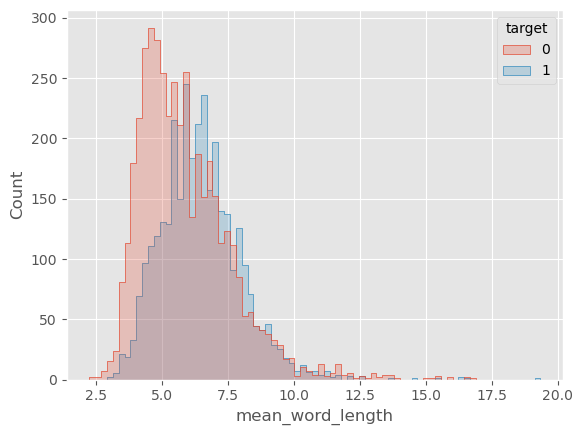

In [ ]:
feat_lst = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length', 'char_count', 'punc_count', 'hashtag_count', 'mention_count']
sns.histplot(add_meta_features(train_df), x='mean_word_length', hue='target', element='step')

## 3. EDA

### 3.1 Target Distribution

<Axes: xlabel='target', ylabel='count'>

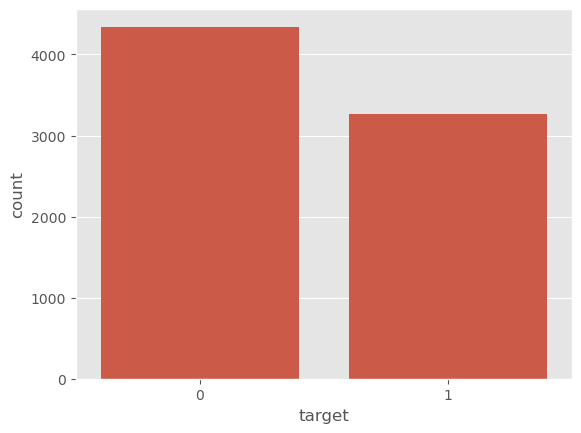

In [17]:
sns.barplot(train_df['target'].value_counts())

### 3.3 Keyword Pattern

Text(0.5, 1.0, 'Disaster tweets')

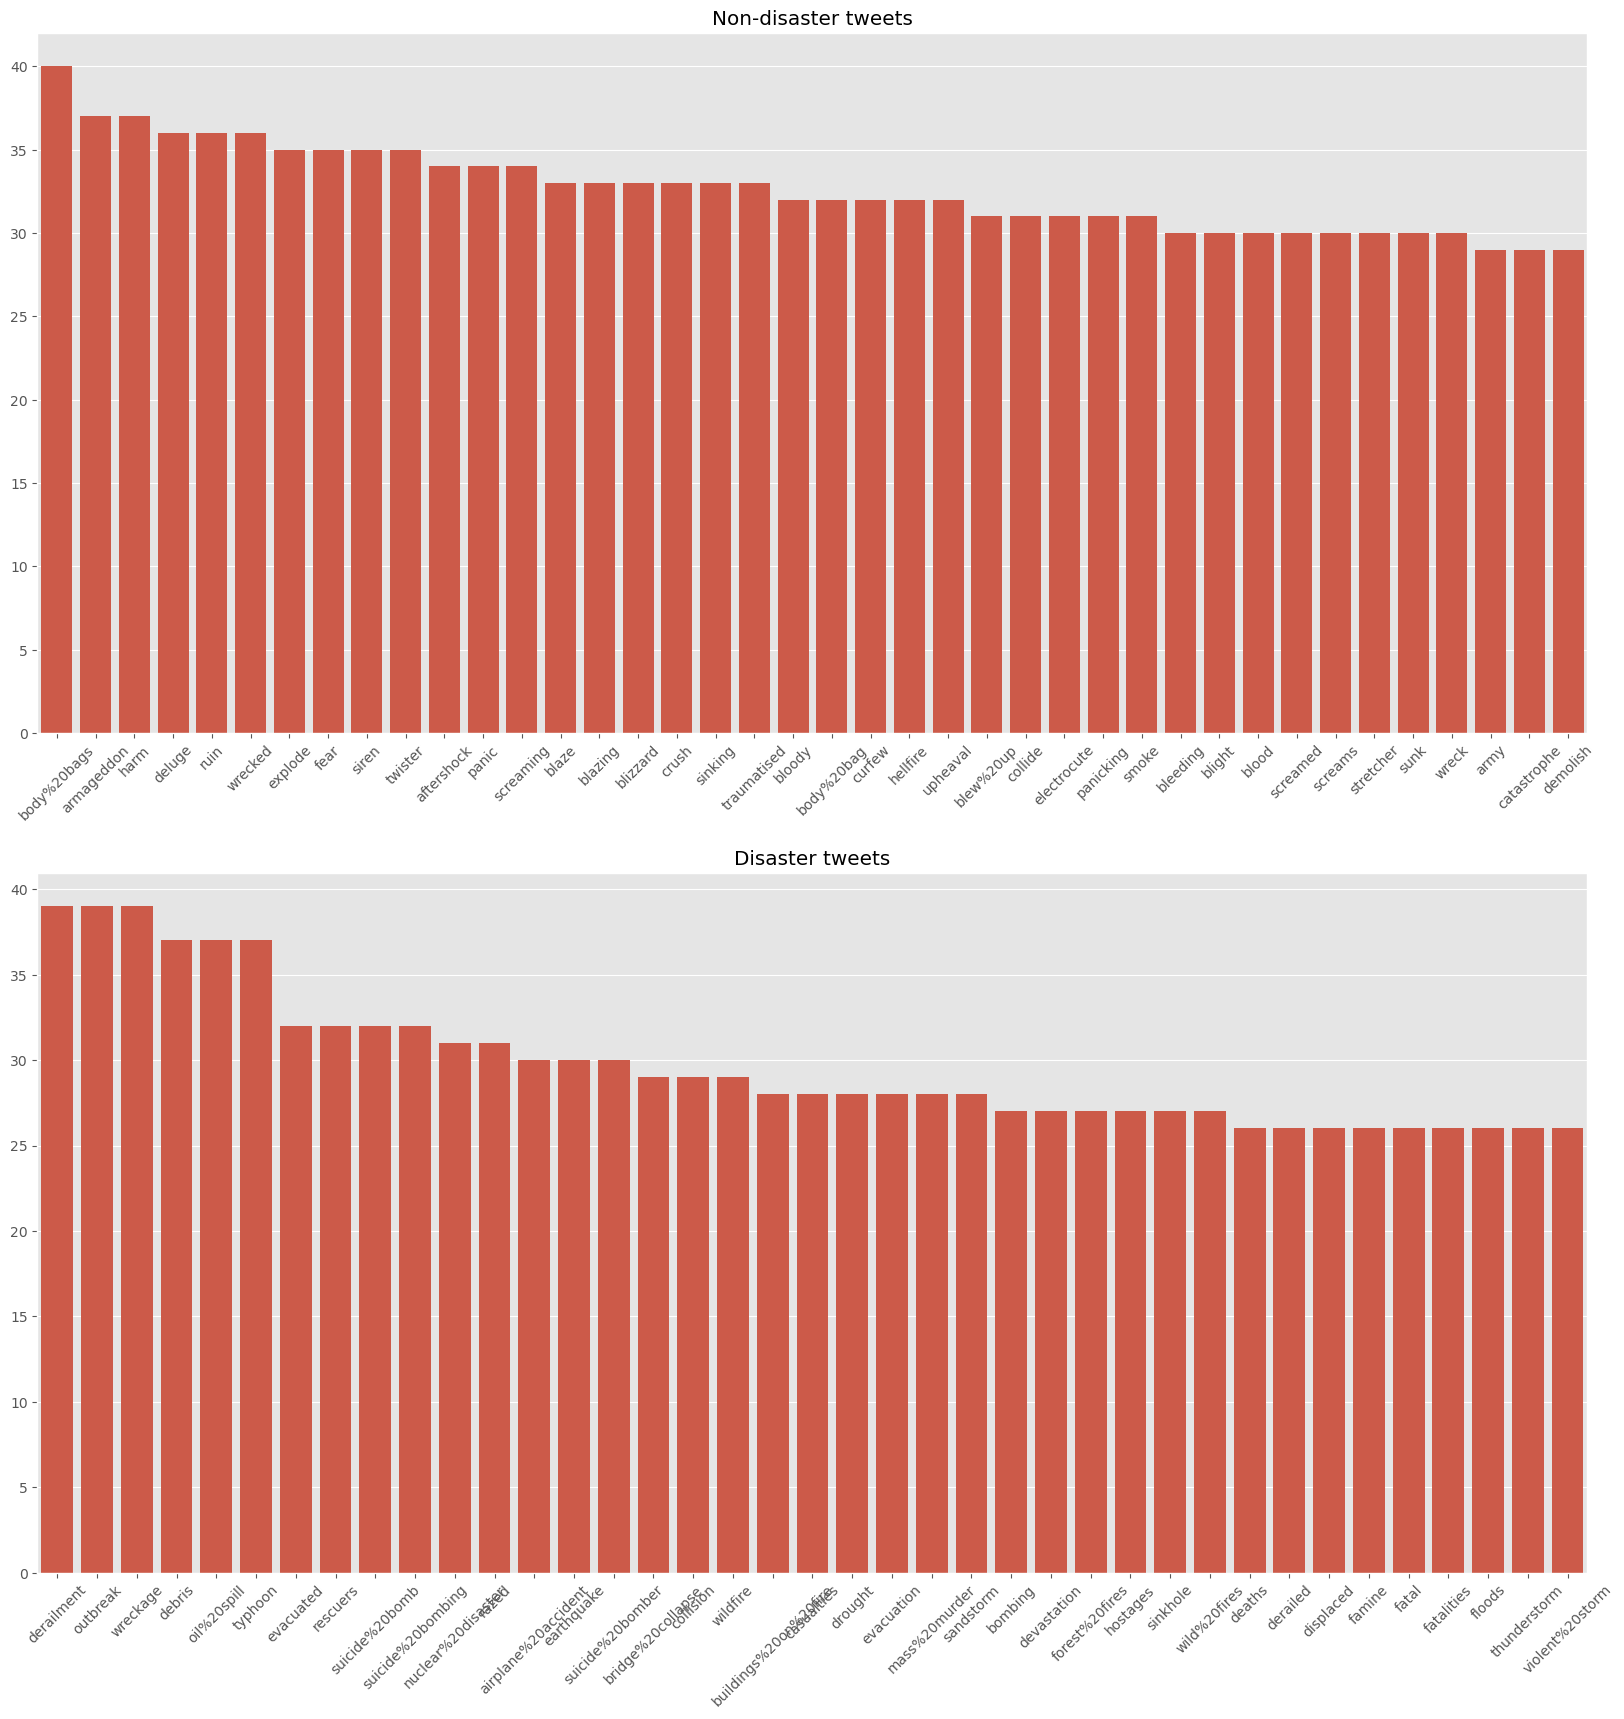

In [ ]:
def freq_tb(df):
    keyword, freq = zip(*sorted(Counter(df['keyword']).items(), key=lambda x: x[1], reverse=True))
    return keyword, freq


fig, ax = plt.subplots(2, 1, figsize=(20, 20))
sns.barplot(
    x=freq_tb(train_df.query('target==0'))[0][:40], 
    y=freq_tb(train_df.query('target==0'))[1][:40], 
    ax=ax[0])
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_title('Non-disaster tweets')
sns.barplot(
    x=freq_tb(train_df.query('target==1'))[0][:40], 
    y=freq_tb(train_df.query('target==1'))[1][:40], 
    ax=ax[1])
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_title('Disaster tweets')

# keyword_0, freq_0 = freq_tb(train_df.query('target==0'))
# keyword_1, freq_1 = freq_tb(train_df.query('target==1'))

# df_0 = pd.DataFrame({'Keyword': keyword_0, 'Frequency': freq_0, 'target': 'Non-disaster'})
# df_1 = pd.DataFrame({'Keyword': keyword_1, 'Frequency': freq_1, 'target': 'Disaster'})
# df_1.sort_values(by=keyword_0)

# fig, ax = plt.subplots(figsize=(20, 10))
# sns.barplot(
#     x=df_0['Keyword'], 
#     y=df_0['Frequency'], 
#     ax=ax,
#     color='red')

# ax.tick_params(axis='x', rotation=45)
# ax.set_title('Non-disaster/disaster tweets')
# sns.barplot(
#     x=df_1['Keyword'], 
#     y=df_1['Frequency'], 
#     ax=ax,
#     color='blue')

<Axes: xlabel='Count', ylabel='keyword'>

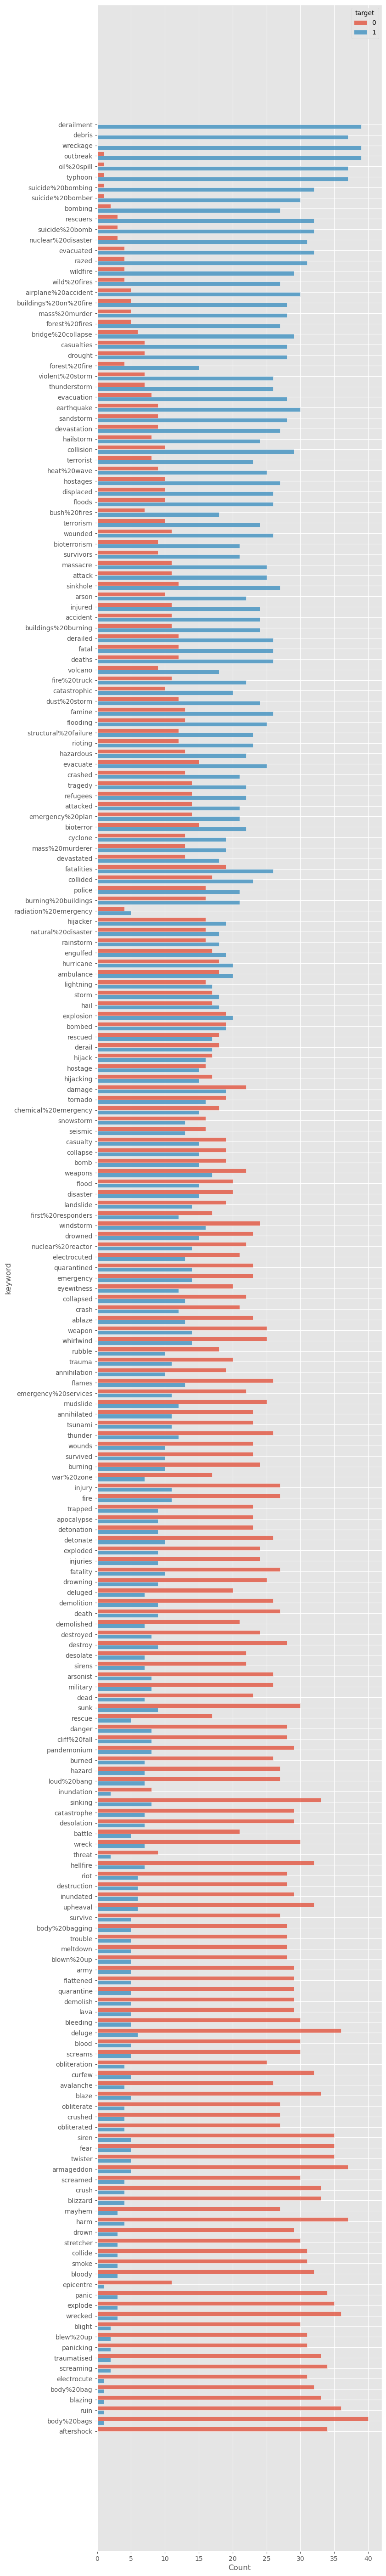

In [ ]:
fig, ax = plt.subplots(figsize=(8, 72))
train_df['target_mean'] = train_df.groupby('keyword')['target'].transform('mean')
sns.histplot(
    y=train_df.sort_values(by='target_mean', ascending=False)['keyword'], 
    hue=train_df.sort_values(by='target_mean', ascending=False)['target'], 
    multiple="dodge", shrink=0.8, ax=ax)

### 3.4 Common stopwords in tweets

In [18]:
corpus = sum(train_df['text'].str.split().tolist(), [])
freq_tb = sorted(Counter(corpus).items(), key=lambda x: x[1], reverse=True)
x, y = zip(*freq_tb)

<Axes: >

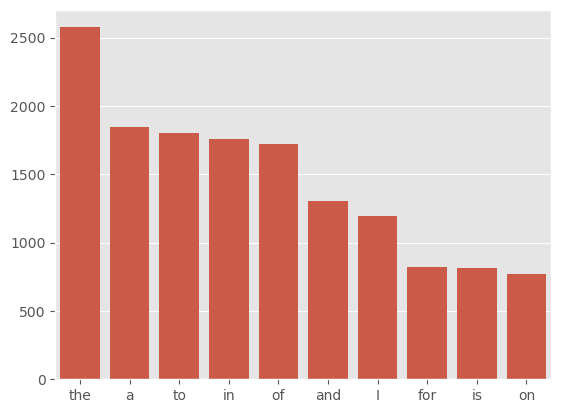

In [19]:
sns.barplot(x=x[:10], y=y[:10])

### 3.4 Analyze punctuations

In [20]:
punc_dict = defaultdict(int)
for i in corpus:
    if i in string.punctuation:
        punc_dict[i] += 1

punc_freq_tb = sorted(punc_dict.items(), key=lambda x: x[1], reverse=True)
punc_x, freq = zip(*punc_freq_tb)

<Axes: >

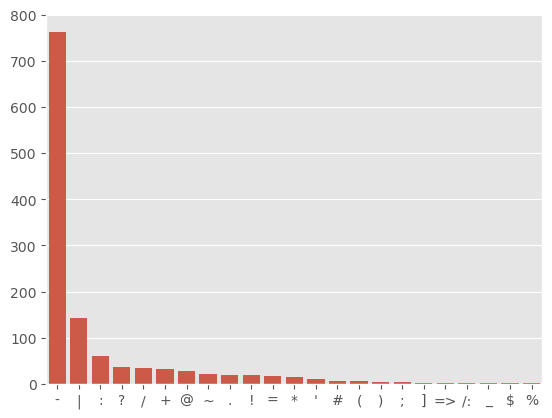

In [21]:
sns.barplot(x=punc_x, y=freq)

In [22]:
vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)

In [45]:
ngram = CountVectorizer(analyzer='char', ngram_range=(2, 2))
bag_of_words = ngram.fit_transform(corpus)

In [37]:
bag_of_words.toarray().shape

(113461, 2580)

In [50]:
len(ngram.get_feature_names_out())

2580

In [48]:
len(ngram.vocabulary_)

2580

In [53]:
vec = CountVectorizer(ngram_range=(2,2))
vec.fit_transform(train_df['text'].tolist())

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 108957 stored elements and shape (7613, 68496)>

In [60]:
sorted(vec.vocabulary_.items(), key=lambda x: x[1], reverse=True)

[('ûówe work', 68495),
 ('ûótech business', 68494),
 ('ûónegligence and', 68493),
 ('ûókody vine', 68492),
 ('ûóher upper', 68491),
 ('ûó wallybaiter', 68490),
 ('ûó the', 68489),
 ('ûó stories', 68488),
 ('ûó rt', 68487),
 ('ûó richmond', 68486),
 ('ûó organizers', 68485),
 ('ûó oh', 68484),
 ('ûó now', 68483),
 ('ûó lol', 68482),
 ('ûó integrates', 68481),
 ('ûó https', 68480),
 ('ûó hiroshima', 68479),
 ('ûó head', 68478),
 ('ûó eh', 68477),
 ('ûó desolation', 68476),
 ('ûó bulletproof', 68475),
 ('ûó britain', 68474),
 ('ûó bbc', 68473),
 ('ûó and', 68472),
 ('ûó an', 68471),
 ('ûòåêcnbc http', 68470),
 ('ûòthe united', 68469),
 ('ûò800000 fatalities', 68468),
 ('ûò ûïdetonate', 68467),
 ('ûò your', 68466),
 ('ûò vladimir', 68465),
 ('ûò video', 68464),
 ('ûò usa', 68463),
 ('ûò two', 68462),
 ('ûò those', 68461),
 ('ûò the', 68460),
 ('ûò steve', 68459),
 ('ûò skyåênews', 68458),
 ('ûò residents', 68457),
 ('ûò part', 68456),
 ('ûò news', 68455),
 ('ûò musicians', 68454),
 ('ûò mo

In [241]:
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

<Axes: >

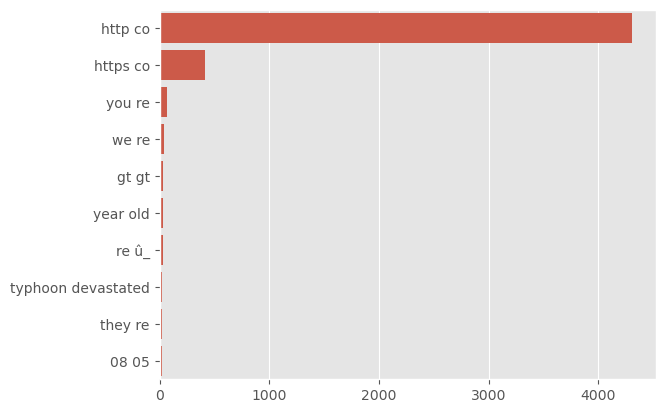

In [242]:
top_tweet_bigrams = words_freq[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

## 4. Data Cleaning

### 4.1 Combine dataframe

In [87]:
full_df = pd.concat([train_df, test_df], axis=0)
full_df

,id,keyword,location,text,target,target_mean,word_count,unique_word_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,NaN,13.0,13.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,NaN,7.0,7.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,NaN,22.0,20.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,NaN,8.0,8.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,NaN,16.0,15.0
...,...,...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN,NaN,NaN,NaN
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN,NaN,NaN,NaN
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN,NaN,NaN,NaN
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN,NaN,NaN,NaN


### 4.2 Text cleaning (If not use large models)

In [88]:
# !pip install spacy
# !python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load('en_core_web_sm')

In [89]:
# 2.1 Removing urls
# example="New competition launched: https://www.kaggle.com/c/nlp-getting-started"
def remove_urls(text):
    pattern = r'https?://\S+|www\.\S+'
    return re.sub(pattern, '', text)

# 2.2 Removing HTML tags
def remove_htmls(text):
    pattern = r'<.*?>'
    return re.sub(pattern, r'', text)

# example = """<div>
# <h1>Real or Fake</h1>
# <p>Kaggle </p>
# <a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
# </div>"""

# remove_htmls(example)


# 2.3 Removing emojis
def remove_emojis(text):
    return re.sub(r"[\U0001F600-\U0001F64F"
                    r"\U0001F300-\U0001F5FF"
                    r"\U0001F680-\U0001F6FF"
                    r"\U0001F1E0-\U0001F1FF"
                    r"\U00002702-\U000027B0"
                    r"\U000024C2-\U0001F251]+", '', text)
    # return emoji_pattern.sub(r'', text)    
# remove_emojis("Omg another Earthquake 😔😔")


# 2.4 Removing punctuations
def remove_punct(text):
    pattern = str.maketrans('', '', string.punctuation)
    return text.translate(pattern)
# example="I am a #king"
# remove_punct(example)


# 2.5 Spelling correction
spell = SpellChecker()
def correct_spelling(text):
    text_lst = text.split()
    misspelled_words = spell.unknown(text_lst)
    for i, word in enumerate(text_lst):
        if word in misspelled_words:
            text_lst[i] = spell.correction(word)  
    return ' '.join(text_lst)

# correct_spelling("corect me plese")

In [90]:
full_df['text'] = (
    full_df['text']
    .apply(remove_urls)
    .apply(remove_htmls)
    .apply(remove_emojis)
    .apply(remove_punct)
    # .apply(correct_spelling)
)

In [91]:
def process_text(text):
    doc = nlp(text)
    tokens = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct]
    lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    pos_tags = [(token.text, token.pos_) for token in doc if not token.is_stop and not token.is_punct]

    return tokens, lemmas, pos_tags

In [92]:
full_df[['tokenized', 'lemmas', 'pos_tags']] = full_df['text'].apply(lambda x: pd.Series(process_text(x)))
full_df['lemma_str'] = full_df['lemmas'].apply(lambda x: ' '.join(x))

In [93]:
full_df

,id,keyword,location,text,target,target_mean,word_count,unique_word_count,tokenized,lemmas,pos_tags,lemma_str
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1.0,NaN,13.0,13.0,"[deeds, reason, earthquake, allah, forgive]","[deed, Reason, earthquake, ALLAH, forgive]","[(Deeds, NOUN), (Reason, PROPN), (earthquake, ...",deed Reason earthquake ALLAH forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1.0,NaN,7.0,7.0,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, La, Ronge, Sask, Canada]","[(Forest, NOUN), (fire, NOUN), (near, ADP), (L...",forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to shelter in place are be...,1.0,NaN,22.0,20.0,"[residents, asked, shelter, place, notified, o...","[resident, ask, shelter, place, notify, office...","[(residents, NOUN), (asked, VERB), (shelter, V...",resident ask shelter place notify officer evac...
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1.0,NaN,8.0,8.0,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfire, evacuation,...","[(13000, NUM), (people, NOUN), (receive, VERB)...",13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1.0,NaN,16.0,15.0,"[got, sent, photo, ruby, alaska, smoke, wildfi...","[get, send, photo, Ruby, Alaska, smoke, wildfi...","[(got, AUX), (sent, VERB), (photo, NOUN), (Rub...",get send photo Ruby Alaska smoke wildfire pour...
...,...,...,...,...,...,...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN,NaN,NaN,NaN,"[earthquake, safety, los, angeles, ûò, safety...","[earthquake, SAFETY, LOS, ANGELES, ÛÒ, SAFETY...","[(EARTHQUAKE, NOUN), (SAFETY, NOUN), (LOS, PRO...",earthquake SAFETY LOS ANGELES ÛÒ SAFETY faste...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane My citya...,NaN,NaN,NaN,NaN,"[storm, ri, worse, hurricane, cityamp3others, ...","[storm, RI, bad, hurricane, cityamp3other, har...","[(Storm, NOUN), (RI, PROPN), (worse, ADJ), (hu...",storm RI bad hurricane cityamp3other hard hit ...
3260,10868,NaN,NaN,Green Line derailment in Chicago,NaN,NaN,NaN,NaN,"[green, line, derailment, chicago]","[Green, Line, derailment, Chicago]","[(Green, PROPN), (Line, PROPN), (derailment, N...",Green Line derailment Chicago
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook HWO,NaN,NaN,NaN,NaN,"[meg, issues, hazardous, weather, outlook, hwo]","[MEG, issue, Hazardous, Weather, Outlook, HWO]","[(MEG, NOUN), (issues, NOUN), (Hazardous, PROP...",MEG issue Hazardous Weather Outlook HWO


### 4.3 Check Vocab alignment (only for not large models)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)
words = set(tokenizer.tokenize(' '.join(train_df['text'].tolist())))
bert_vocab = set(tokenizer.vocab.keys())

In [ ]:
def print_overlapping(bert_vocab, words):
    # Compute overlap
    common_words = words.intersection(bert_vocab)
    percentage_in_bert = (len(common_words) / len(words)) * 100 if words else 0

    # Print results
    print(f"Total words in text: {len(words)}")
    print(f"Words in BERT vocab: {len(common_words)}")
    print(f"Percentage of words in BERT vocab: {percentage_in_bert:.2f}%")

In [ ]:
print_overlapping(bert_vocab, words)

Total words in text: 12978
Words in BERT vocab: 12978
Percentage of words in BERT vocab: 100.00%


## 5. Building Model

In [61]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    
    print(f'There\'re {torch.cuda.device_count()} available')
    print(f'We will use the GPU: {torch.cuda.get_device_name(0)}')
    
else:
    print('No GPU available ...')
    device = torch.device('cpu') 

No GPU available ...


In [125]:
combined_df = pd.concat([train_df, test_df]).reset_index(drop=True)
labels = train_df['target']
combined_df

,id,keyword,location,text,target,target_mean,word_count,unique_word_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,NaN,13.0,13.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,NaN,7.0,7.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,NaN,22.0,20.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,NaN,8.0,8.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,NaN,16.0,15.0
...,...,...,...,...,...,...,...,...
10871,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN,NaN,NaN,NaN
10872,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN,NaN,NaN,NaN
10873,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN,NaN,NaN,NaN
10874,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN,NaN,NaN,NaN


In [127]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [129]:
max_len = 0

for text in combined_df['text']:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    
    input_ids = tokenizer(text, add_special_tokens=True)['input_ids']

    # Update the maximum sentence length.
    
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  84


In [132]:
token_lens = []

for text in combined_df['text']:
    tokens = tokenizer(text, max_length=512)
    token_lens.append(len(tokens['input_ids']))

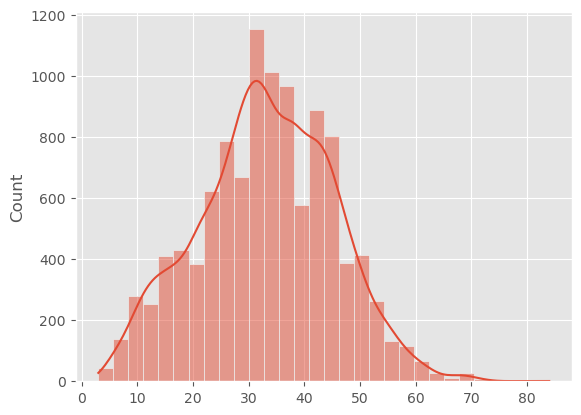

In [133]:
# Displaying sentence length dist.
fig, axes = plt.subplots()
sns.histplot(token_lens, bins=30, kde=True)
plt.show()

In [137]:
type(tokenizer(train_df['text'][0])['input_ids'])

list

In [183]:
def tokenize_map(sentences, tokenizer, labels=None):
    input_ids = []
    attention_masks = []
    
    for text in sentences:
        token_res = tokenizer(text, 
                              add_special_tokens = True,
                              truncation='longest_first',
                              max_length = 84,
                              padding = 'max_length',
                              return_attention_mask = True,
                              return_tensors = 'pt')
        
        input_ids.append(token_res['input_ids'])
        attention_masks.append(token_res['attention_mask'])
        
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if labels is None:
        return input_ids, attention_masks
    else:
        labels =  torch.tensor(labels)
        return input_ids, attention_masks, labels

In [184]:
input_ids, attention_masks, labels = tokenize_map(train_df['text'].tolist(), tokenizer, train_df['target'].astype('int32').tolist())
test_input_ids, test_attention_masks= tokenize_map(test_df['text'].tolist(), tokenizer)

In [206]:
test_input_ids

tensor([[  101,  2074,  3047,  ...,     0,     0,     0],
        [  101,  2657,  2055,  ...,     0,     0,     0],
        [  101,  2045,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2665,  2240,  ...,     0,     0,     0],
        [  101, 12669,  3314,  ...,     0,     0,     0],
        [  101,  1001,  2103,  ...,     0,     0,     0]])

In [204]:
import pickle

In [205]:
dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks)

with open('dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)
    
with open('test_dataset.pkl', 'wb') as f:
    pickle.dump(test_dataset, f)

In [191]:
dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [192]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_dataset, 
    sampler = RandomSampler(train_dataset),
    batch_size = BATCH_SIZE
    )


val_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
        )

In [193]:
model = BertForSequenceClassification.from_pretrained('bert-large-uncased',
                                                      num_labels=2, 
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [194]:
optimizer = AdamW(model.parameters(), 
                  lr = 6e-6, 
                  eps = 1e-8)

In [203]:
NUM_EPOCHS = 3

total_steps = len(train_dataloader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=8, num_training_steps=total_steps)

## 6. Model Training/Evaluation

In [202]:
from sklearn.metrics import accuracy_score, f1_score
from torch.nn.utils import clip_grad_norm_

In [200]:
def flat_accuracy(preds, labels):
    
    """A function for calculating accuracy scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):
    
    """A function for calculating f1 scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return f1_score(labels_flat, pred_flat)

In [ ]:
training_stats = []


for epoch_i in range(NUM_EPOCHS):
    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    
    total_train_loss = 0
    
    model.train()
    
    for i, batch in enumerate(train_dataloader):
        # Progress update every 50 batches.
        if i % 50 == 0 and not i == 0:
            # Report progress.
            print(f'  Batch {i}  of  {len(train_dataloader)}')
            
        b_input_ids = batch[0].to(device).to(torch.int64)
        b_input_mask = batch[1].to(device).to(torch.int64)
        b_labels = batch[2].to(device).to(torch.int64)
        
        optimizer.zero_grad()
        
        loss, logits = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
        
        total_train_loss += loss.item()
        
        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
            
    avg_train_loss = total_train_loss / len(train_dataloader)
    
    
    print('')
    print('  Average training loss: {0:.2f}'.format(avg_train_loss))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.

    print('')
    print('Running Validation...')
    
    
    model.eval()
    
    # Tracking variables:
    
    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0
    num_eval_steps = 0
    
    
    
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        
        with torch.no_grad():
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        # Move logits and labels to CPU:
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        
        # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches:
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)
        
        
        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
        print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))
        
        # Report the final f1 score for this validation run.
        
        avg_val_f1 = total_eval_f1 / len(val_dataloader)
        print('  F1: {0:.2f}'.format(avg_val_f1))

        # Calculate the average loss over all of the batches.
        
        avg_val_loss = total_eval_loss / len(val_dataloader)
        
        # Record all statistics from this epoch.
    
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Val_F1' : avg_val_f1
            }
        )

        print('')
        print('Training complete!')